<a href="https://colab.research.google.com/github/xo0ol/Object-Detection-Yolov8---Peanut/blob/main/Object_Detection_Yolov11_Peanut.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **개요**

1. 환경 확인
2. 학습용 데이터 준비
3. Train, Test 데이터 나누기
4. Yolo 실행을 위한 data.yaml 파일 생성
5. 모델 훈련 시작
6. 모델 결과 확인
7. 새 데이터로 예측하기
8. 훈련된 모델을 사용하여 peanut_test_video.mp4 영상 객체 탐지
9. 땅콩이 이미지 추출

___

# 1. 환경 확인

In [ ]:
# NVIDIA GPU 가용 확인
!nvidia-smi

Sat Aug 23 13:24:00 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# 2. 학습용 데이터 준비

In [ ]:
# 땅콩이 객체가 라벨링된 데이터를 [peanut_roboflow_data_unzip] 폴더로 압축 해제
!unzip -q /content/peanut_roboflow_data.zip -d /content/peanut_roboflow_data_unzip

___

# 3. Train, Test 데이터 나누기

In [ ]:
# github에서 공유된 train_val_split.py 스크립트 불러오기
!wget -O /content/train_val_split.py https://raw.githubusercontent.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/refs/heads/main/utils/train_val_split.py

# train, test 7:3 비율로 나누기
!python train_val_split.py --datapath="/content/peanut_roboflow_data_unzip" --train_pct=0.7

--2025-08-23 13:27:24--  https://raw.githubusercontent.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/refs/heads/main/utils/train_val_split.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3203 (3.1K) [text/plain]
Saving to: ‘/content/train_val_split.py’

/content/train_val_ 100%[===================>]   3.13K  --.-KB/s    in 0s      

2025-08-23 13:27:25 (52.1 MB/s) - ‘/content/train_val_split.py’ saved [3203/3203]

Created folder at /content/data/train/images.
Created folder at /content/data/train/labels.
Created folder at /content/data/validation/images.
Created folder at /content/data/validation/labels.
Number of image files: 812
Number of annotation files: 812
Images moving to train: 730
Images moving to validation: 82


___

# 4. Yolo 실행을 위한 data.yaml 파일 생성

In [ ]:
# yaml 파일을 생성하는 함수 만들기
import yaml
import os

def create_data_yaml(path_to_classes_txt, path_to_data_yaml):

  # classes.txt 파일에서 class name 가져오기
  if not os.path.exists(path_to_classes_txt):
    print(f'classes.txt file not found! Please create a classes.txt labelmap and move it to {path_to_classes_txt}')
    return
  with open(path_to_classes_txt, 'r') as f:
    classes = []
    for line in f.readlines():
      if len(line.strip()) == 0: continue
      classes.append(line.strip())
  number_of_classes = len(classes)

  # data dictionary 생성
  data = {
      'path': '/content/data',
      'train': 'train/images',
      'val': 'validation/images',
      'nc': number_of_classes,
      'names': classes
  }

  # yaml 파일 쓰기
  with open(path_to_data_yaml, 'w') as f:
    yaml.dump(data, f, sort_keys=False)
  print(f'Created config file at {path_to_data_yaml}')

  return

Created config file at /content/data.yaml

File contents:

path: /content/data
train: train/images
val: validation/images
nc: 1
names:
- peanut


In [ ]:
# 경로 설정
path_to_classes_txt = '/content/classes.txt' # 데이터 라벨이 적힌 txt파일의 경로 설정
path_to_data_yaml = '/content/data.yaml' # 생성된 yaml 파일을 저장할 경로 설정

# 함수 실행
create_data_yaml(path_to_classes_txt, path_to_data_yaml)

# 생성된 yaml 파일 확인하기
print('\nFile contents:\n')
!cat /content/data.yaml

___

# 5. 모델 훈련 시작

In [ ]:
# ultralytics 불러오기
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.7 MB/s eta 0:00:00


In [ ]:
!yolo detect train data=/content/data.yaml model=yolo11s.pt epochs=50 imgsz=640 batch=8 # 에포크, 배치 사이즈, 이미지 사이즈 설정

Ultralytics 8.3.184 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, pro

# 6. 모델 결과 확인

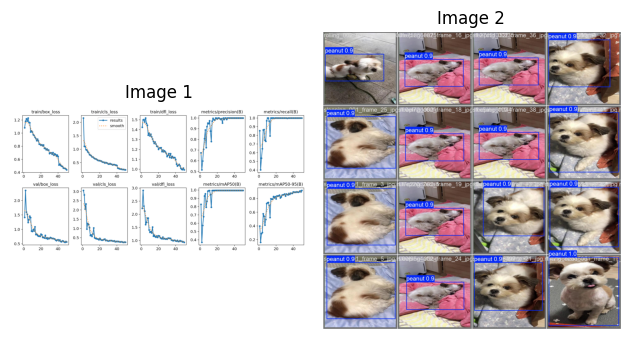

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# 결과 파일 경로 설정
img1 = mpimg.imread('/content/results.png')
img2 = mpimg.imread('/content/val_batch2_pred.jpg')

# 1행 2열의 서브플롯을 생성하고 첫 번째 칸 선택
plt.subplot(1, 2, 1)
plt.imshow(img1)
plt.title('Image 1') # 첫 번째 이미지 제목
plt.axis('off')  # 축 숨기기

# 1행 2열의 서브플롯에서 두 번째 칸 선택
plt.subplot(1, 2, 2)
plt.imshow(img2)
plt.title('Image 2') # 두 번째 이미지 제목
plt.axis('off') # 축 숨기기

# 서브플롯 간의 간격 조정
plt.tight_layout()

# 그래프 출력
plt.show()

# 7. 새 데이터로 예측하기

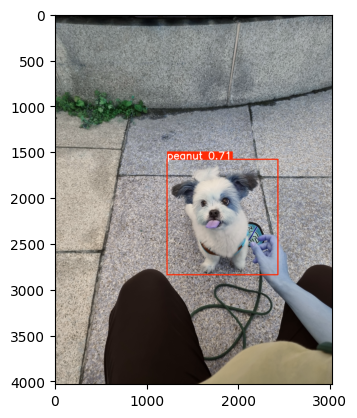

In [ ]:
annotated_frame = results[0].plot()

# 결과 이미지 출력
plt.imshow(annotated_frame)

___

# 8. 훈련된 모델을 사용하여 peanut_test_video.mp4 영상 객체 탐지

In [ ]:
import cv2

# 영상 경로 지정
video_path = r"/content/peanut_test_video.mp4" # 객체 탐지에 사용될 영상의 경로 설정
output_path = r"/content/peanut_test_video_output.mp4" # output을 저장할 경로 설정

# OpenCV로 영상 읽기
cap = cv2.VideoCapture(video_path)

# 영상 파일을 제대로 불러왔는지 확인
if not cap.isOpened():
    raise Exception(f"영상 파일을 열 수 없습니다: {video_path}")

# 영상의 기본 정보 가져오기
fps = cap.get(cv2.CAP_PROP_FPS) # 초당 프레임 수
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)) # 프레임 너비
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)) # 프레임 높이

# 객체 탐지 결과가 담긴 영상을 저장하기 위한 cv2.VideoWriter 객체 생성
fourcc = cv2.VideoWriter_fourcc(*'mp4v') # 코덱 : fourcc
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

# 프레임 단위로 객체 탐지
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # 객체 탐지
    results = model.predict(frame)

    # 탐지 결과 그리기
    for result in results:
        annotated_frame = result.plot()  # YOLOv8이 제공하는 plot()으로 바운딩 박스 그림

    # cv2.VideoWriter 객체의 write() 함수를 사용해 탐지 결과가 표시된 프레임을 결과 동영상에 한 장씩 추가
    out.write(annotated_frame)

# VideoWriter 객체에 대한 메모리 해제
cap.release()
out.release()


0: 640x384 1 peanut, 10.9ms
Speed: 3.3ms preprocess, 10.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 peanut, 12.2ms
Speed: 3.2ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 peanut, 12.6ms
Speed: 3.6ms preprocess, 12.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 peanut, 13.3ms
Speed: 3.2ms preprocess, 13.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 peanut, 12.9ms
Speed: 3.4ms preprocess, 12.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 peanut, 12.0ms
Speed: 3.3ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 peanut, 12.8ms
Speed: 3.2ms preprocess, 12.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 peanut, 11.3ms
Speed: 3.2ms preprocess, 11.3ms inference, 1.5ms postprocess per image at shape (1, 3, 64

# 9. 땅콩이 이미지 추출

In [12]:
# 영상 속에서 땅콩이 객체를 추출하여 peanut_test_video_output 폴더에 저장
## src > utils > extract_objects_from_video.py 실행

!python extract_objects_from_video.py /content/yolov11_peanut_e50_b8.pt /content/peanut_test_video.mp4 /content/peanut_test_video_output 0.5

모델 로드 완료: /content/yolov11_peanut_e50_b8.pt
모델: /content/yolov11_peanut_e50_b8.pt
비디오: /content/peanut_test_video.mp4
출력 폴더: /content/peanut_test_video_output
신뢰도 임계값: 0.5
--------------------------------------------------
객체 추출 시작...

0: 640x384 1 peanut, 54.2ms
Speed: 4.0ms preprocess, 54.2ms inference, 136.5ms postprocess per image at shape (1, 3, 640, 384)
저장됨: frame_0001_object_0001.jpg (신뢰도: 0.680)

0: 640x384 1 peanut, 10.9ms
Speed: 3.0ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)
저장됨: frame_0002_object_0002.jpg (신뢰도: 0.655)

0: 640x384 1 peanut, 11.0ms
Speed: 2.9ms preprocess, 11.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 384)
저장됨: frame_0003_object_0003.jpg (신뢰도: 0.619)

0: 640x384 1 peanut, 11.6ms
Speed: 3.2ms preprocess, 11.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)
저장됨: frame_0004_object_0004.jpg (신뢰도: 0.578)

0: 640x384 1 peanut, 10.8ms
Speed: 3.1ms preprocess, 10.8ms inference, 1.3ms p

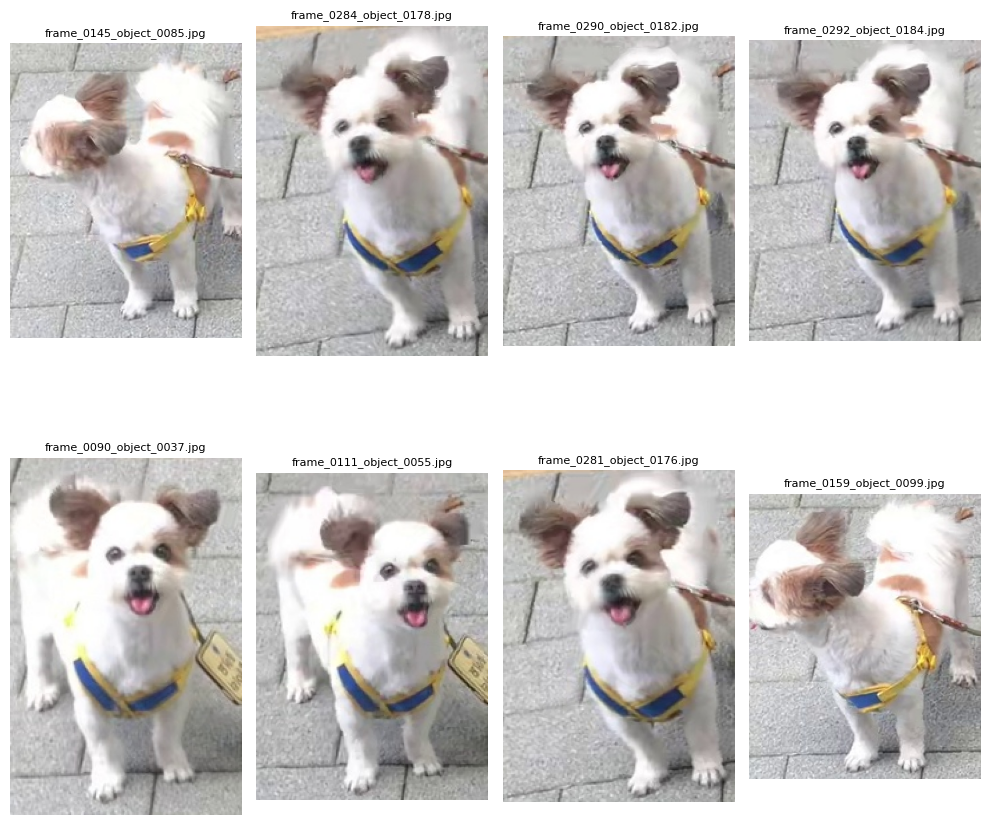

In [38]:
from display_images_from_folder import display_images_from_folder


image_folder = '/content/peanut_test_video_output'
display_images_from_folder(
    folder_path=image_folder,
    num_images=8,
    rows=2,
    cols=4,
    figsize=(10,10)
)

___

# **END**